# Basic usage of `stoflo`: Soil evapotranspiration

We solve a soil water balance, given by

$$\frac{dS}{dt}=P-E-D$$

where $S$ (mm) is soil storage, $t$ (d) is time, $P$ (mm/d) is precipitation which infiltrates into the soil, $E$ (mm/d) is actual evaporation, $D$ (mm/d) is soil drainage.

$P$ is a exogenous variable.

$E$ is given by

$$E=\left \{\begin{array}{lc}
0 & S<R_c\\
E_p\frac{S-R_c}{S_m-R_c} & R_c<S<S_m\\
E_p & S>=S_m\\
\end{array}\right .$$

and $D$ is given by

$$D=\left \{ \begin{array}{lc}
C(S-F_c) & S> F_c\\
0 & S\leq F_c
\end{array}\right .$$

where the model parameters are:

$R_c$ (mm) root constant<br>
$F_c$ (mm) field capacity<br>
$S_m$ (mm) Unstressed evaporation storage threshold<br>
$C$ (1/d) Drainage rate coefficient

and $E_p$ (mm/d) is the potential evaporation.

In this model $P$ is added as a driver. $E_p$ is included as a time series parameter.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from stoflo import model

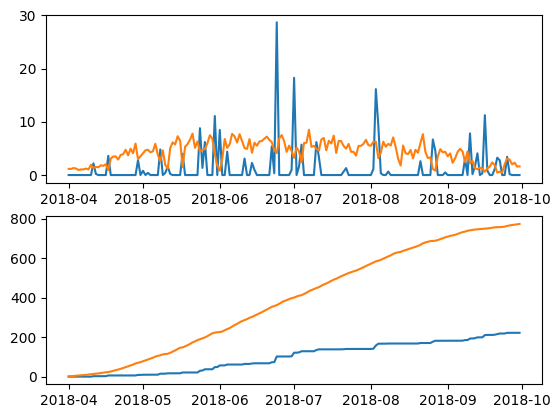

In [2]:
# Load precipitation and potential evaporation data
dd=pd.read_csv('metData.txt',sep=r"\s+") #delim_whitespace=True)
dd.index=pd.date_range(start='1-Oct-2017',freq='D',periods=len(dd))
start='2018-04-01'
end='2018-9-30'
dd=dd.loc[start:end]

pl.subplot(2,1,1)
pl.plot(dd['Prcp'])
pl.plot(dd['ET0'])
pl.subplot(2,1,2)
pl.plot(dd['Prcp'].cumsum())
pl.plot(dd['ET0'].cumsum())

In [3]:
# Create a model:
s=model()

In [4]:
# Add time grid information:
s.addTime(dt=1,tMax=len(dd)-1)

In [5]:
# Add stock(s):
s.addStock('S',300)

In [6]:
# Add flow(s):
def evapFun(t,stocks,pars):
    waterStress=(stocks['S']-pars['RC'])/(pars['SMAX']-pars['RC'])
    if waterStress>1.: waterStress=1.0
    if waterStress<0.: waterStress=0.0
    ET=pars['PE'][int(t)]*waterStress
    return ET
s.addFlow('evapFun',evapFun,outfrom='S')

def drainageFun(t,stocks,pars):
    D=(stocks['S']-pars['FC'])*pars['C']
    if D<0: D=0.
    return D
s.addFlow('drainageFun',drainageFun,outfrom='S')

In [7]:
# Add driver(s):
s.addDriver('P',dd['Prcp'].values,into='S')

In [8]:
# Add parameters
pars={}
pars['PE']=dd['ET0'].values
pars['SMAX']=300
pars['RC']=100
pars['FC']=280
pars['C']=0.5
s.addPars(pars)

In [9]:
# Run model
s.runEuler()

In [10]:
# Calculate other model outputs:
AE=np.zeros(s.nt)
D=np.zeros(s.nt)
for i in range(s.nt):
    AE[i]=evapFun(s.t[i],{x: s.stocks[x][i] for x in s.stocks},pars)
    D[i]=drainageFun(s.t[i],{x: s.stocks[x][i] for x in s.stocks},pars)

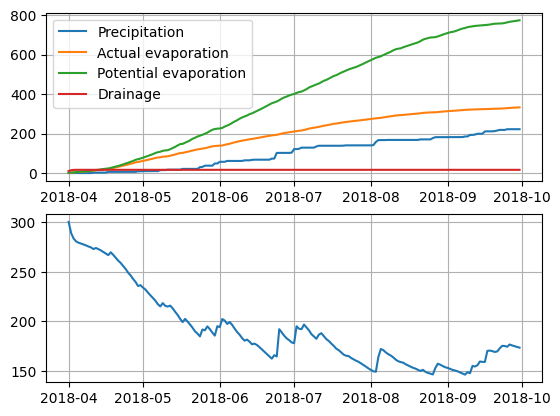

In [11]:
pl.subplot(2,1,1)
pl.plot(dd['Prcp'].cumsum(),label='Precipitation')
pl.plot(dd.index,AE.cumsum(),label='Actual evaporation')
pl.plot(dd['ET0'].cumsum(),label='Potential evaporation')
pl.plot(dd.index,D.cumsum(),label='Drainage')
pl.legend()
pl.grid()

pl.subplot(2,1,2)
pl.plot(dd.index,s.stocks['S'],label='Soil moisture')
pl.grid()
pl.show()

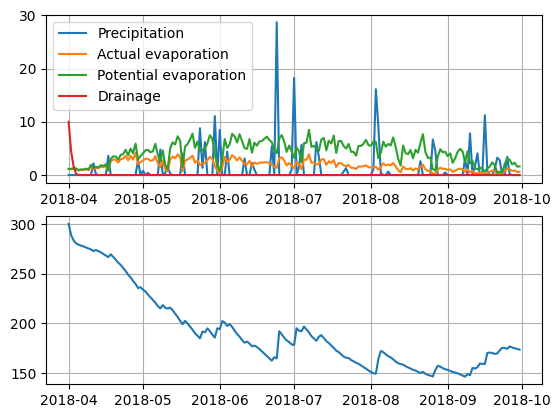

In [13]:
pl.subplot(2,1,1)
pl.plot(dd['Prcp'],label='Precipitation')
pl.plot(dd.index,AE,label='Actual evaporation')
pl.plot(dd['ET0'],label='Potential evaporation')
pl.plot(dd.index,D,label='Drainage')
pl.legend()
pl.grid()

pl.subplot(2,1,2)
pl.plot(dd.index,s.stocks['S'],label='Soil moisture')
pl.grid()
pl.show()